In [1]:
import numpy as np 
import os

import cv2
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.feature_extraction.image import extract_patches_2d

In [3]:
from skimage.feature import (match_descriptors, ORB) 

In [4]:
from sklearn.cluster import KMeans

In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets

## Parametros

In [5]:
n_features=20 #Ajusta el numero de caracteristicas que entrega el descriptor de ORB

n_patches=50 #Parámetro para ajustar número de Patches

n_clust=200 #Ajusta el numero de clusters para ajustar Kmeans

F=32*n_features #32 es el largo de los descriptores de ORB


## P1

In [6]:
#Obtenemos una lista con los paths de las imagenes
def getFiles(path):
    images = []
    for file in  os.listdir(os.path.join(path)):
        images.append(os.path.join(path, os.path.join(file)))

    return images

In [7]:
#Carpeta donde guardamos las imagenes
Folder_path=r"C:\Users\jorge\Desktop\Jorge U\s9\Lab inteligencia\proyecto\pain"

In [8]:
Image_paths = getFiles(Folder_path)

In [9]:
#Importamos las imagenes
def readImage(list):
    imgs=[]
    for file in list:
        #Leemos la imagen en escala de grises
        img = cv2.imread(file, 0)
        imgs.append(img)
    return imgs
    

In [10]:
#Lista de imagenes del dataset
Imgs= readImage(Image_paths)

In [11]:
#Obtenemos los tags de cada imagen para saber de que persona son para crear los datasets
def getTags(list):
    tags=[]
    y=[]
    for file in list:
        tag=file[len(Folder_path)+1:len(file)]
        tags.append(tag)
    for tag in tags:
        if tag[2].isdigit()==True:
            tag=tag[0:3]
            y.append(tag)
        else:
            tag=tag[0:2]
            y.append(tag)
    return y 

In [12]:
Tags= getTags(Image_paths)

In [13]:
#Obtenemos los datasets
X_train, X_test, y_train, y_test = train_test_split(Imgs, Tags, test_size=0.2, random_state=1)

In [14]:
n_train=(len(X_train)) #Cantidad de imagenes en dataset de entrenamiento

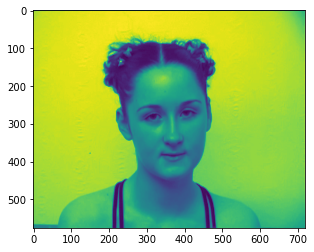

In [15]:
plt.imshow(X_train[0])

In [16]:
print(y_train[0])


f13


## P2

In [17]:
#P2: Obtenemos features de una imagen mediante ORB de CV2... Es mas rapido que SKIMAGE

def getDescriptors(image,n_feat=n_features):
    orb = cv2.ORB_create(nfeatures= n_feat,fastThreshold=0, edgeThreshold=0)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return descriptors

## P3

In [18]:
#P3

def getPatches(list):
    patches=[]
    X_size=144
    Y_size=180
    window_shape = (X_size, Y_size)
    for img in list:
        patch = extract_patches_2d(img,window_shape,max_patches=n_patches)
        patches.append(patch)
    return patches

In [19]:
#Obtenemos los patches de cada imágen
Xtrain_patches=getPatches(X_train)
Xtrain_patches=np.asarray(Xtrain_patches)

In [20]:
#Tamaño del conjunto de patches de las imágnenes
Xtrain_patches.shape

(479, 50, 144, 180)

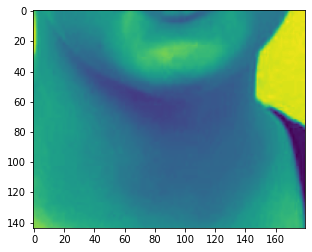

In [21]:
#Ejemplo de patch 
plt.imshow(Xtrain_patches[0][1])

## P4

In [22]:
#P4

#Obtenemos los descriptores de todas las imágenes/patches
def descriptorExtractor(Imglist):
    descriptors=[]
    i=0
    for i in range(0,len(Imglist)):
        for j in range(0,n_patches):
            img = Imglist[i][j]
            desc = getDescriptors(img)
            descriptors.append(desc)
    return descriptors
        

In [23]:
X_train_Descriptors = descriptorExtractor(Xtrain_patches)

In [24]:
X_train_Descriptors = np.asarray(X_train_Descriptors,dtype=object)

In [25]:
X_train_Descriptors.shape

(23950, 20, 32)

## P5

In [26]:
X_train_Descriptors=[item for sublist in X_train_Descriptors for item in sublist]

In [28]:
X_train_Descriptors = np.asarray(X_train_Descriptors,dtype=object)
X_train_Descriptors.shape

(479000, 32)

In [29]:
#P5

def kmeans(descriptors, no_clusters=n_clust):
    km = KMeans(n_clusters = no_clusters).fit(descriptors)
    return km


def getClusters(kmeans,descriptors, no_clusters=n_clust):
    centroids=kmeans.cluster_centers_
    return centroids


In [30]:
kmeans_ = kmeans(X_train_Descriptors)

In [31]:
Clusters=getClusters(kmeans_,X_train_Descriptors)

In [32]:
Clusters.shape

(200, 32)

## P6

In [41]:
#Funcion auxiliar paa obtener los descriptores de una imagen uniendo todos sus patches
def getImageDescriptors(descriptors,n_img):
    desc=descriptors[n_img*n_patches]
    i=1
    while i<n_patches*n_features:
        union=descriptors[n_img*(n_patches*n_features) +i]
        desc = np.concatenate((desc, union), axis=0)
        i+=1
    desc=np.reshape(desc,(-1,32))
    return desc  

In [42]:
a=getImageDescriptors(X_train_Descriptors,478)
a.shape

(1000, 32)

In [77]:
def EncodingTrain(kmeans,descriptors,n_clusters = n_clust ,n_images = n_train):
    Features = np.array([np.zeros(n_clusters) for i in range(n_images)])
    i=0
    while i<n_images:
        feature=getImageDescriptors(X_train_Descriptors,i)
        km_p=kmeans.predict(feature)
        for k in km_p:
            Features[i][k]+=1
        i+=1
    return Features

In [78]:
X_train_feat=EncodingTrain(kmeans_,X_train_Descriptors)

In [68]:
X_train_feat.shape

(479, 200)

In [79]:
def plotHistogram(im_features, no_clusters):
    x = np.arange(no_clusters)
    y = im_features

    plt.bar(x, y)
    plt.xlabel("Cluster")
    plt.ylabel("Frecuencia")
    plt.title("Histograma BOW")
    plt.show()

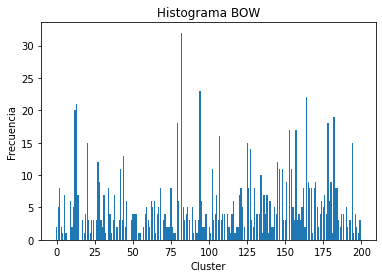

In [82]:
plotHistogram(X_train_feat[0], n_clust)

## P7

In [88]:
#Dividimos las imágenes de test en patches
Xtest_patches=getPatches(X_test)
Xtest_patches=np.asarray(Xtest_patches)

#Obtenemos los descriptores de test usando ORB
X_test_Descriptors = descriptorExtractor(Xtest_patches)

X_test_Descriptors=[item for sublist in X_test_Descriptors for item in sublist]
X_test_Descriptors = np.asarray(X_test_Descriptors,dtype=object)

In [89]:
X_test_Descriptors.shape

(120000, 32)

## P8

In [94]:
C=Clusters.shape[0]

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(Clusters, range(C))

KNeighborsClassifier(n_neighbors=1)

## P9

In [95]:
n_test=len(X_test)

def EncodingTest(knn,descriptors,n_clusters = n_clust ,n_images = n_test):
    Features = np.array([np.zeros(n_clusters) for i in range(n_images)])
    i=0
    while i<n_images:
        feature=getImageDescriptors(descriptors,i)
        knn_p=knn.predict(feature)
        for k in knn_p:
            Features[i][k]+=1
        i+=1
    return Features


In [96]:
X_test_feat=EncodingTest(classifier,X_test_Descriptors)

In [98]:
X_test_feat.shape

(120, 200)

## P10

In [113]:
parameters = {'C':[0.1, 0.2, 0.5, 1, 2, 5], 
              'kernel':['rbf','linear','poly','sigmoid'],
              'class_weight':['balanced'],
              'gamma':['auto','scale',0.1,1,5],
              'decision_function_shape':['ovo']}

SVC_ = GridSearchCV(SVC(), parameters,scoring='accuracy')

In [114]:
SVC_.fit(X_train_feat, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.5, 1, 2, 5],
                         'class_weight': ['balanced'],
                         'decision_function_shape': ['ovo'],
                         'gamma': ['auto', 'scale', 0.1, 1, 5],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='accuracy')

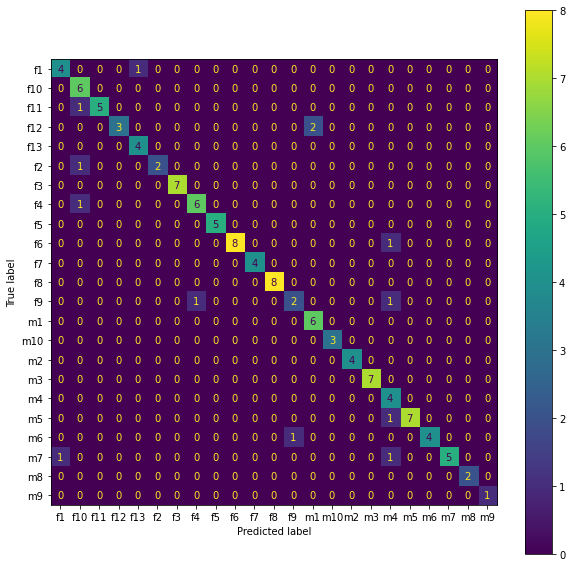

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_predict= SVC_.predict(X_test_feat)

cm= confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVC_.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

In [116]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.8916666666666667